# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from scipy.stats import skew

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn import decomposition
from category_encoders import TargetEncoder
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import optuna
from optuna.samplers import TPESampler

## Load data

In [3]:
load_test = pd.read_csv('test.csv')
load_train = pd.read_csv('train.csv')
pd.set_option('max_columns', None)

### Uploading a file with pre-obtained targets

In [4]:
load_test_Saleprice = pd.read_csv('saleprice.csv')
load_test['SalePrice'] = load_test_Saleprice['SalePrice']
df = pd.concat([load_train, load_test], axis=0)
df.set_index('Id', inplace=True)

### Removing outliers

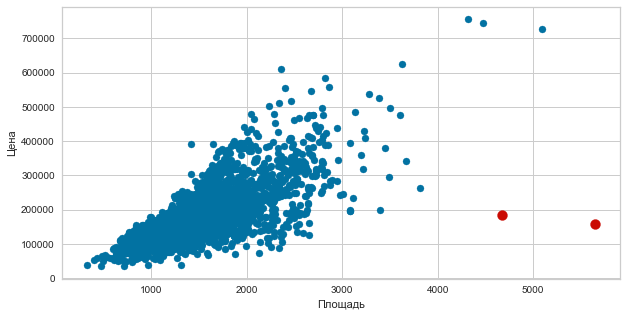

In [5]:
plt.figure(figsize=(10, 5))
v = df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)]
plt.scatter(df['GrLivArea'], df['SalePrice'])
plt.scatter(v['GrLivArea'], v['SalePrice'], c='r', s=100)
plt.xlabel('Площадь')
plt.ylabel('Цена');

In [6]:
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)

### Delete

In [7]:
len(df) - df[df['Utilities'] == 'AllPub']['Utilities'].count()

3

In [8]:
df = df.drop('Utilities', axis=1)
df.index = range(1,2918)

### Let's change the categorical and numerical features

In [10]:
objectt = list(df.select_dtypes(include=['object']).columns)
num = list(df.select_dtypes(exclude=['object']).columns)
num.remove('SalePrice')

In [11]:
objectt = list(df.select_dtypes(include=['object']).columns)
num = list(df.select_dtypes(exclude=['object']).columns)
num.remove('SalePrice')
for el in ['MSSubClass', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'GarageCars', 'MoSold']:
    objectt.append(el)
    num.remove(el)

### Fill in the missing values

In [12]:
df[num] = df[num].fillna(df[num].median())

### Year in age

In [13]:
df['YearBuilt'] = 2017 - df['YearBuilt']
df['YearRemodAdd'] = 2017 - df['YearRemodAdd']
df['YrSold'] = 2017 - df['YrSold']
df['GarageYrBlt'] = 2017 - df['GarageYrBlt']

In [14]:
df[objectt] = df[objectt].fillna('No')

In [15]:
df['YearRemodAdd'][1875] = 15

C:\Users\pavel\AppData\Local\Temp/ipykernel_14732/2691179196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YearRemodAdd'][1875] = 15


In [16]:
df[(df['YearBuilt'] - df['YearRemodAdd']) < 0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


### Getting rid of heavy tails

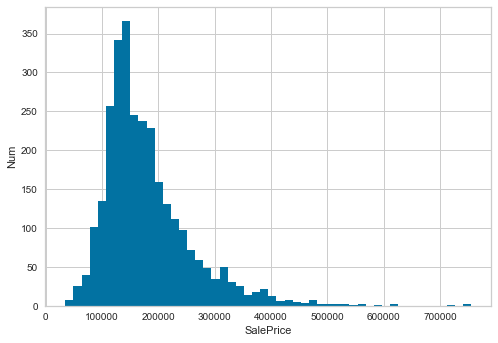

In [17]:
plt.hist(df['SalePrice'], bins=50)
plt.xlabel('SalePrice')
plt.ylabel('Num');

In [18]:
skewness = df[num].apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

skewness = skewness[abs(skewness) > 0.5]

skew_features = df[skewness.index[:-2]]
lam = 0.15
for feat in skew_features:
    df[feat] = boxcox1p(df[feat], lam)

df['SalePrice'] = np.log1p(df['SalePrice'])

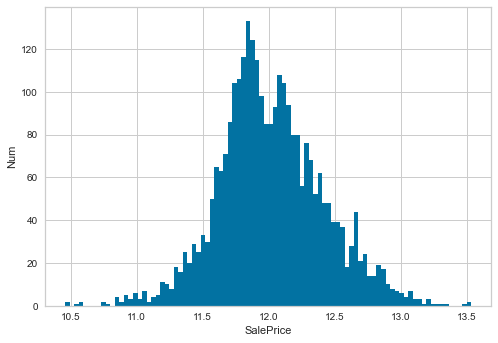

In [19]:
plt.hist(df['SalePrice'], bins=90)
plt.xlabel('SalePrice')
plt.ylabel('Num');

### Target Encoder

In [20]:
cat = []
obuniq = df[objectt].nunique()
for i in range(len(obuniq)):
    if obuniq.values[i] <=6:
        cat.append(obuniq.index[i])

In [21]:
for el in cat:
    encoder = TargetEncoder()
    df[el] = encoder.fit_transform(df[el], df['SalePrice'])

### Correlations

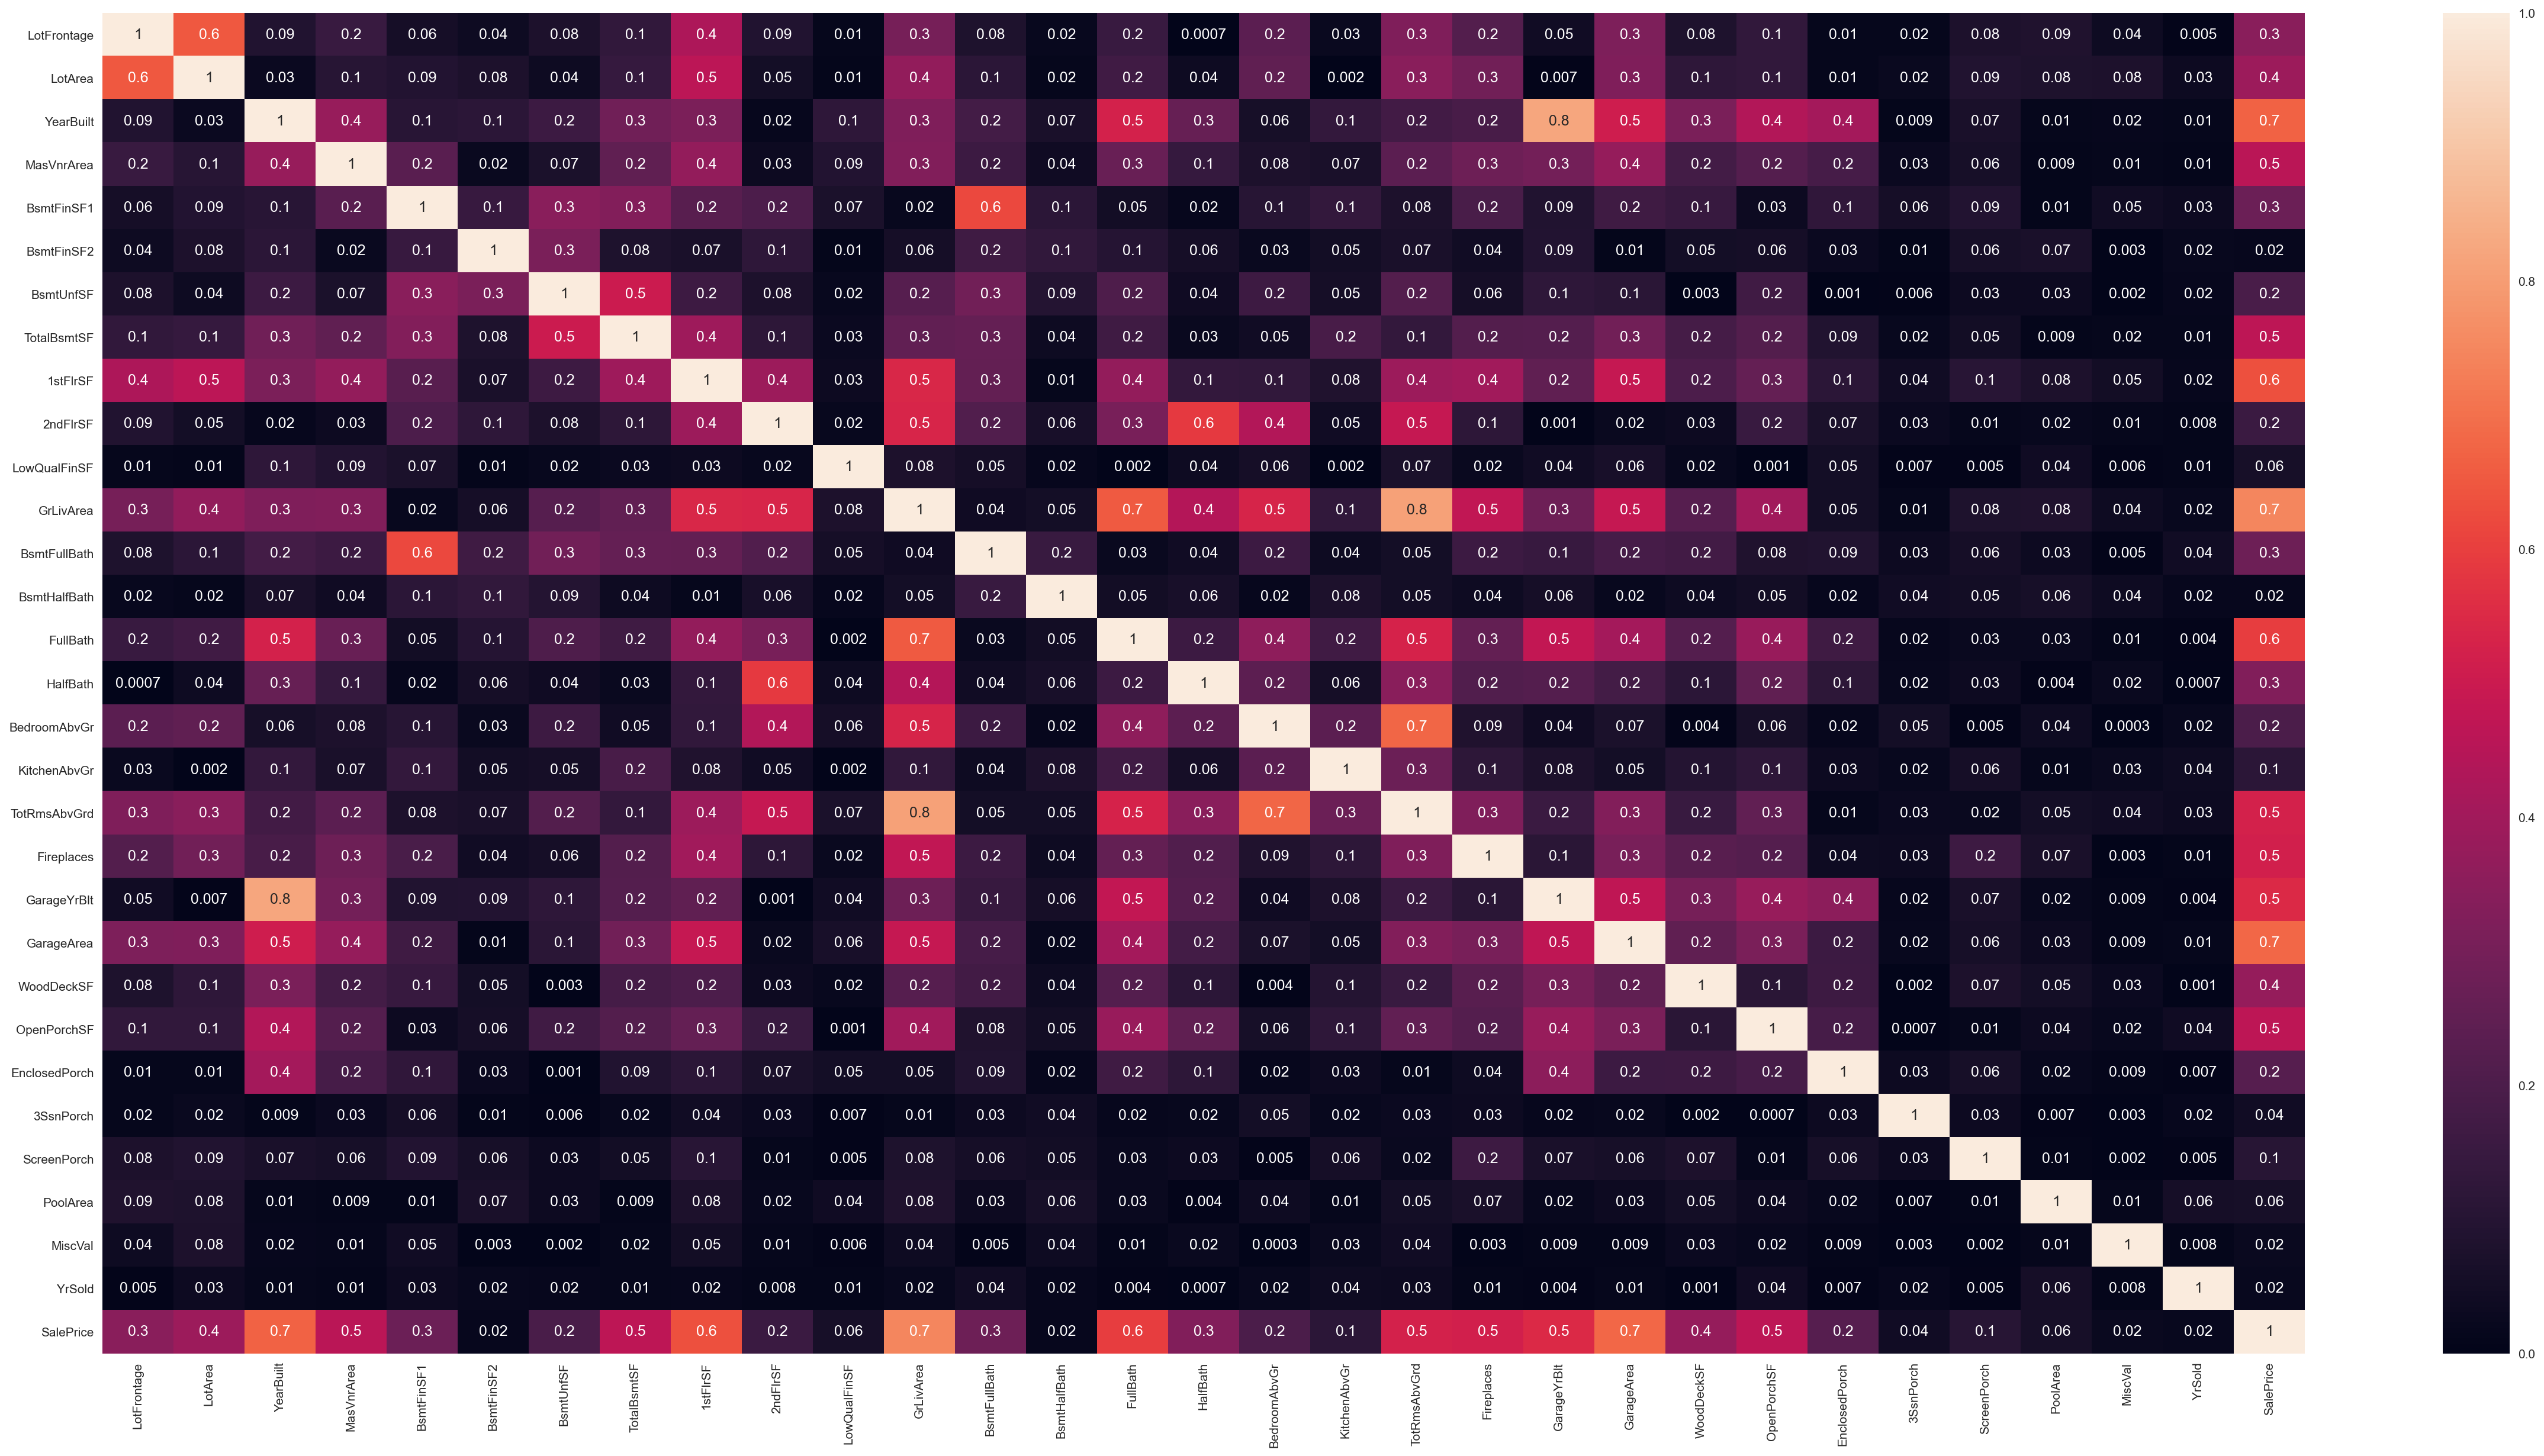

In [22]:
num.append('SalePrice')
plt.figure(figsize=(40,20), dpi=150)
sns.heatmap(df[num].corr().abs(),
                cbar=True,
                 annot=True, vmin=0, vmax=1, fmt='.1g')
num.remove('SalePrice')

Check (GarageCars GarageArea), (YearBuilt GarageYrBlt), (GrLivArea TotRmsAbvGrd), (1stFlrSF TotalBsmtSF)

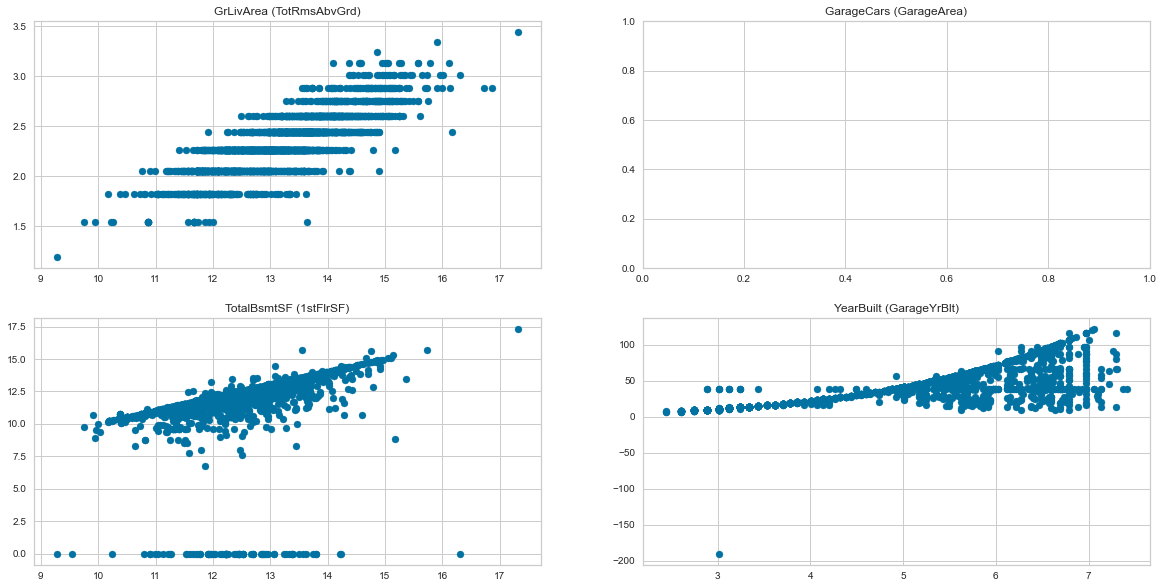

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs[1, 0].set_title('TotalBsmtSF (1stFlrSF)')
axs[0, 1].set_title('GarageCars (GarageArea)')
axs[1, 1].set_title('YearBuilt (GarageYrBlt)')
axs[0, 0].set_title('GrLivArea (TotRmsAbvGrd)')
axs[1, 0].scatter(df['1stFlrSF'], df['TotalBsmtSF'])
#axs[0, 1].scatter(df['GarageCars'], df['GarageArea'])
axs[1, 1].scatter(df['YearBuilt'], df['GarageYrBlt'])
axs[0, 0].scatter(df['GrLivArea'], df['TotRmsAbvGrd'])

In [24]:
# pca = decomposition.PCA(n_components=1)
# #pca = UMAP(n_components=1)
# X_centered = df[['GarageCars', 'GarageArea']]
# pca.fit(X_centered)
# X_pca = pca.transform(X_centered)
# df['newnewnew'] = X_pca
# df = df.drop(['GarageArea'], axis=1)

In [25]:
# pca1 = decomposition.PCA(n_components=1)
# #pca1 = UMAP(n_components=1)
# X_centered1 = df[['YearBuilt', 'GarageYrBlt']]
# pca1.fit(X_centered1)
# X_pca1 = pca1.transform(X_centered1)
# df['newnewnew1'] = X_pca1
# df = df.drop(['GarageYrBlt', 'YearBuilt'], axis=1)

In [26]:
# pca2 = decomposition.PCA(n_components=1)
# #pca2 = UMAP(n_components=1)
# X_centered2 = df[['GrLivArea', 'TotRmsAbvGrd']]
# pca2.fit(X_centered2)
# X_pca2 = pca2.transform(X_centered2)
# df['newnewnew2'] = X_pca2
# df = df.drop(['TotRmsAbvGrd'], axis=1)

In [27]:
# pca3 = decomposition.PCA(n_components=1)
# #pca3 = UMAP(n_components=1)
# X_centered3 = df[['1stFlrSF', 'TotalBsmtSF']]
# pca3.fit(X_centered3)
# X_pca3 = pca3.transform(X_centered3)
# df['newnewnew3'] = X_pca3
# df = df.drop(['TotalBsmtSF', '1stFlrSF'], axis=1)

### Clustering poorly correlated features with the target

In [28]:
bad_corr = ['YrSold', 'MiscVal', 'PoolArea', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch', 'KitchenAbvGr', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath', 'LowQualFinSF', '2ndFlrSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'LotFrontage']

In [29]:
X = StandardScaler().fit_transform(df[bad_corr])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

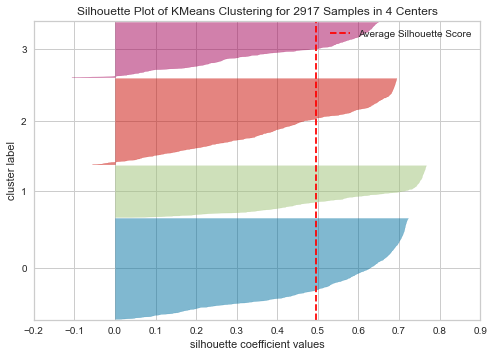

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2917 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_pca)
visualizer.show()

In [31]:
km = KMeans(4)
km.fit(X_pca)
df['Bad_corr'] = km.labels_

### Numeric feature clustering

In [32]:
X = StandardScaler().fit_transform(df[num])
umap = UMAP(n_components=3, n_neighbors=5)
X_umap = umap.fit_transform(X)

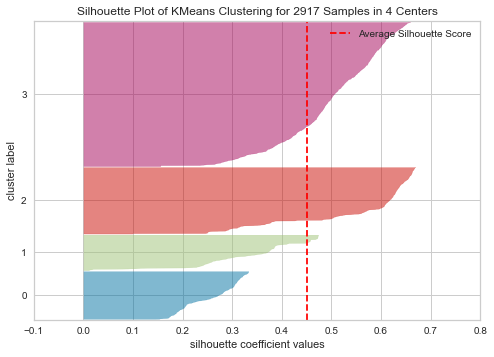

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2917 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_umap)
visualizer.show()

In [34]:
km = KMeans(4)
km.fit(X_umap)
df['Corr_num'] = km.labels_

### Encoding

In [35]:
df_encoding = pd.get_dummies(df)

## Training and test split

In [36]:
ss_scaler = StandardScaler()
ss_scaler.fit(df_encoding[num])
df_encoding[num] = ss_scaler.transform(df_encoding[num])

In [37]:
x_df_test = df_encoding[1458:].drop('SalePrice', axis=1)
y_df_train = df_encoding[:1458]['SalePrice']
x_df_train = df_encoding[:1458].drop('SalePrice', axis=1)

In [38]:
x_train, x_valid, y_train, y_valid = train_test_split(x_df_train, y_df_train.to_numpy(), random_state=42, test_size = 0.5)

## Train

### Optuna

In [39]:
# # 1. Define an objective function to be maximized.
# def objective(trial):
#     # 2. Suggest values for the hyperparameters using a trial object.
#     eta = trial.suggest_float('eta', 0, 1)
#     gamma = trial.suggest_int('gamma', 0, 10)
#     max_depth = trial.suggest_int('max_depth', 0, 5)
#     min_child_weight = trial.suggest_int('min_child_weight', 0, 2)
#     n_estimators = trial.suggest_int('n_estimators', 0, 1000)
#     # Models
#     regr_obj = XGBRegressor(eta=eta, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, verbose=0)
#     # Fit    
#     regr_obj_data = regr_obj.fit(x_train, y_train)
#     pred = regr_obj_data.predict(x_valid)
#     error = mean_squared_error(np.expm1(y_valid), np.expm1(pred))
#     return error
# XGBRegressor
# # 3. Create a study object and optimize the objective function.
# optune = optuna.create_study(direction='minimize')
# optune.optimize(objective, n_trials=500, show_progress_bar=False)
# optune.best_params

In [40]:
# def objective(trial):
#     X_train, X_valid, y_train, y_valid = train_test_split(x_df_train, y_df_train.to_numpy(), random_state=0, test_size = 0.1)

#     param = {
#         "learning_rate": trial.suggest_float("learning_rate", 0.0, 1),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
#         ),
#         "used_ram_limit": "3gb",
#     }

#     reg = CatBoostRegressor(silent = True, **param)

#     reg.fit(X_train, y_train)

#     return mean_squared_error(y_valid, reg.predict(X_valid))

# optune = optuna.create_study(direction='minimize')
# optune.optimize(objective, n_trials=500, show_progress_bar=False)
# optune.best_params

In [41]:
lin = (LinearRegression())
       
lin.fit(x_train, y_train)
er_lin = mean_squared_error(np.expm1(lin.predict
                                     (x_valid)), np.expm1(y_valid))
print("train mse:", mean_squared_error(np.expm1(lin.predict(x_train)), np.expm1(y_train)))
print("test mse:", er_lin)

train mse: 289242363.1859703
test mse: 542598170.5258151


In [42]:
lass = LassoCV(alphas=np.arange(0.0001, 0.01, 0.001))

lass.fit(x_train, y_train)
er_lass = mean_squared_error(np.expm1(lass.predict(x_valid)), np.expm1(y_valid))
print("train mse:", mean_squared_error(np.expm1(lass.predict(x_train)), np.expm1(y_train)))
print("test mse:", er_lass)

train mse: 424763804.218498
test mse: 467697787.886682


In [43]:
ridg = RidgeCV(alphas=np.arange(1, 10, 0.1))

ridg.fit(x_train, y_train)

er_ridg = mean_squared_error(np.expm1(ridg.predict(x_valid)), np.expm1(y_valid))
print("train mse:", mean_squared_error(np.expm1(ridg.predict(x_train)), np.expm1(y_train)))
print("test mse:", er_ridg)

train mse: 331624794.23588604
test mse: 428763934.76271975


In [47]:
gbr = GradientBoostingRegressor(max_depth=2, learning_rate = 0.1, n_estimators=100)

gbr.fit(x_train, y_train)
er_gbr = mean_squared_error(np.expm1(gbr.predict(x_valid)), np.expm1(y_valid))
print("train mse:", mean_squared_error(np.expm1(gbr.predict(x_train)), np.expm1(y_train)))
print("test mse:", er_gbr)

train mse: 296615786.7992306
test mse: 606086882.8868243


In [48]:
def blend(x, a=0.5, m1=lass, m2=gbr):
    return (a * m1.predict(x)) + ((1 - a) * m2.predict(x))

print("test MSE:", mean_squared_error(np.expm1(blend(x_valid)), np.expm1(y_valid)))

test MSE: 487385230.67853963


In [59]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=7)

rfr.fit(x_train, y_train)
er_rfr = mean_squared_error(np.expm1(rfr.predict(x_valid)), np.expm1(y_valid))
print("train mse:", mean_squared_error(np.expm1(rfr.predict(x_train)), np.expm1(y_train)))
print("test mse:", er_rfr)

train mse: 228933824.41179958
test mse: 786678535.716156


CatBoostRegressor + optuna: learning_rate: 0.06051124830985223, depth: 5, boosting_type: Plain, bootstrap_type: MVS

In [60]:
cat = CatBoostRegressor(depth=5, learning_rate = 0.06051124830985223,  silent = True, boosting_type='Plain', bootstrap_type='MVS')

cat.fit(x_train, y_train)
er_cat = mean_squared_error(np.expm1(cat.predict(x_valid)), np.expm1(y_valid))
print("train mse:", mean_squared_error(np.expm1(cat.predict(x_train)), np.expm1(y_train)))
print("test mse:", er_cat)

train mse: 13631529.23752821
test mse: 505811784.01166046


In [61]:
estimators = [('cat', CatBoostRegressor(depth=5, learning_rate = 0.06051124830985223,  silent = True, boosting_type='Plain', bootstrap_type='MVS')), 
              ('lass', LassoCV(alphas=np.arange(0.0001, 0.01, 0.001)))]
stack_cat_lass_xgb = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(eta=0.2, max_depth=2, n_estimators=300))
stack_cat_lass_xgb.fit(x_df_train, y_df_train.to_numpy())

er_test_cat_lass_xgb = mean_squared_error(np.expm1(stack_cat_lass_xgb.predict(x_valid)), np.expm1(y_valid))
print("train mse:", mean_squared_error(np.expm1(stack_cat_lass_xgb.predict(x_train)), np.expm1(y_train)))
print("test mse:", er_test_cat_lass_xgb)

train mse: 266741702.62535733
test mse: 185282045.89714062


XGBRegressor + optuna: 'eta': 0.20718698488536588,
 'gamma': 0,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 356

In [62]:
model = XGBRegressor(eta= 0.2, max_depth=2, n_estimators=300)

model.fit(x_train, y_train.ravel())
er_model = mean_squared_error(np.expm1(model.predict(x_valid)), np.expm1(y_valid))
print("train mse:", mean_squared_error(np.expm1(model.predict(x_train)), np.expm1(y_train)))
print("test mse:", er_model)

train mse: 82874580.42590055
test mse: 532422719.84312385


In [63]:
print("test MSE:", mean_squared_error(np.expm1(blend(x_valid, m1=ridg, a=0.5)), np.expm1(y_valid)))

test MSE: 463303899.511312


In [65]:
print("test MSE:", mean_squared_error(np.expm1(blend(x_valid, m1=stack_cat_lass_xgb, m2=ridg,a=0.9)), np.expm1(y_valid)))

test MSE: 190791066.08477005


# TEST!

In [66]:
estimators = [('cat', CatBoostRegressor(depth=5, learning_rate = 0.06051124830985223,  silent = True, boosting_type='Plain', bootstrap_type='MVS')), 
              ('lass', LassoCV(alphas=np.arange(0.0001, 0.01, 0.001)))]
stack_cat_lass_xgb = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(eta=0.2, max_depth=2, n_estimators=300))
stack_cat_lass_xgb.fit(x_df_train, y_df_train.to_numpy())

ridg_test = RidgeCV(alphas=np.arange(1, 10, 0.1))
ridg_test.fit(x_df_train, y_df_train.to_numpy())


best_test = np.expm1(0.35*stack_cat_lass_xgb.predict(x_df_test) + 0.65*ridg_test.predict(x_df_test))

In [67]:
best_test.shape

(1459,)

In [68]:
d = {'Id': range(1461, 2920), 'SalePrice': best_test}
test_df = pd.DataFrame(d)

In [69]:
test_df.index = test_df.index + 1
test_df

,Id,SalePrice
1,1461,115298.799479
2,1462,159359.501028
3,1463,181187.475696
4,1464,197948.507560
5,1465,191555.746258
...,...,...
1455,2915,84103.767839
1456,2916,84098.769237
1457,2917,172481.656306
1458,2918,118262.521714


In [70]:
test_df.to_csv('submission.csv', header=True, index=False)

In [71]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m ""